In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import sys
sys.path.append('/Users/kelly/koskella_lab')
from tools import *

In [5]:
#define functions

def rsquared(x, y):
    """ Return R^2 where x and y are arrays."""

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

def plot_with_r_squared(df, x_col, y_col, lower = 0, upper=20, decimals=4, title = None):
    """
    Filters the DataFrame based on the threshold, calculates R^2, and plots a scatterplot with regression line.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        x_col (str): Name of the column to use as x-axis in the plot.
        y_col (str): Name of the column to use as y-axis in the plot.
        upper, lower (float): Thresholds for filtering x_col values. Default to 0 and 20.
        decimals (int): Number of decimal places for R^2 display.
    """
    
    # Filter the DataFrame
    df_filtered = df[(df[x_col] < upper) & (df[x_col] > lower)]

    # Calculate R^2
    r_squared = rsquared(df_filtered[x_col], df_filtered[y_col])

    # Plot with Seaborn
    sns.lmplot(data=df_filtered, x=x_col, y=y_col, fit_reg=True, height=4, aspect=1.8)
    plt.text(0.88, 0.95, f"$R^2 = {r_squared:.{decimals}f}$",
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='right')
    plt.xlabel(f"OD at {x_col}")
    plt.ylabel(f"OD at {y_col}")
    plt.title(title)
    plt.show()
    
def plot_timeseries(dataframe, title = None):
    """
    Plots scatter plots for each column in the given DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing data to plot.
    """
    plt.figure(figsize=(11, 6))  # Optional: Set the figure size
    for column in dataframe.columns:
        sns.scatterplot(data=dataframe, x=dataframe.index, y=dataframe[column], label=column, s=11)
    
    plt.xlabel('Time (hr)')
    plt.ylabel('OD reading') 
    plt.title(title)  # Optional: Title for the plot
    plt.legend(title='Series', bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=3)  # Adjust the location as needed
    plt.tight_layout()  # Adjust layout to make room for the legend
    plt.show()


def clean_and_transpose(df, start_row=32, end_row=106):
    """
    Transposes and cleans a DataFrame for analysis.

    Parameters:
        df (pd.DataFrame): Original DataFrame with raw data.
        start_row (int): Row index to start selecting data from.
        end_row (int): Row index to end selecting data at.
        time_divisor (float): Value to divide the index by for time conversion, default is 3600 (seconds to hours).
        
    Returns:
        pd.DataFrame: Transformed DataFrame with numeric index and cleaned columns.
    """
    # Select the specified rows
    new_df = df.iloc[start_row:end_row]
    
    # Transpose the data so each series is in one column
    df_transposed = new_df.T
    
    # Rename columns to series numbers using the first row
    df_transposed.columns = df_transposed.iloc[0]
    
    # Drop the original row now used as column names
    df_transposed = df_transposed[1:]
    
    # Set the index to the time column and convert to hours
    df_transposed.index = pd.to_numeric(df_transposed.iloc[:, 0], errors='coerce') / 3600
    
    # Drop the index and temporary column, keep only data columns
    cleaned_df = df_transposed.iloc[:, 2:]
    
    # Remove the column name
    cleaned_df.columns.name = 'Series'
    
    # Convert all remaining data to numeric, handling errors
    cleaned_df = cleaned_df.apply(pd.to_numeric, errors='coerce')
    
    return cleaned_df


In [6]:
#read csv file
df = pd.read_csv('/Users/kelly/Desktop/CE_KH_RBG100324.csv')

In [8]:
#clean table
cleaned_df = clean_and_transpose(df, start_row=31, end_row=101)

Text(0.5, 1.0, 'Full OD readings across 24 hours')

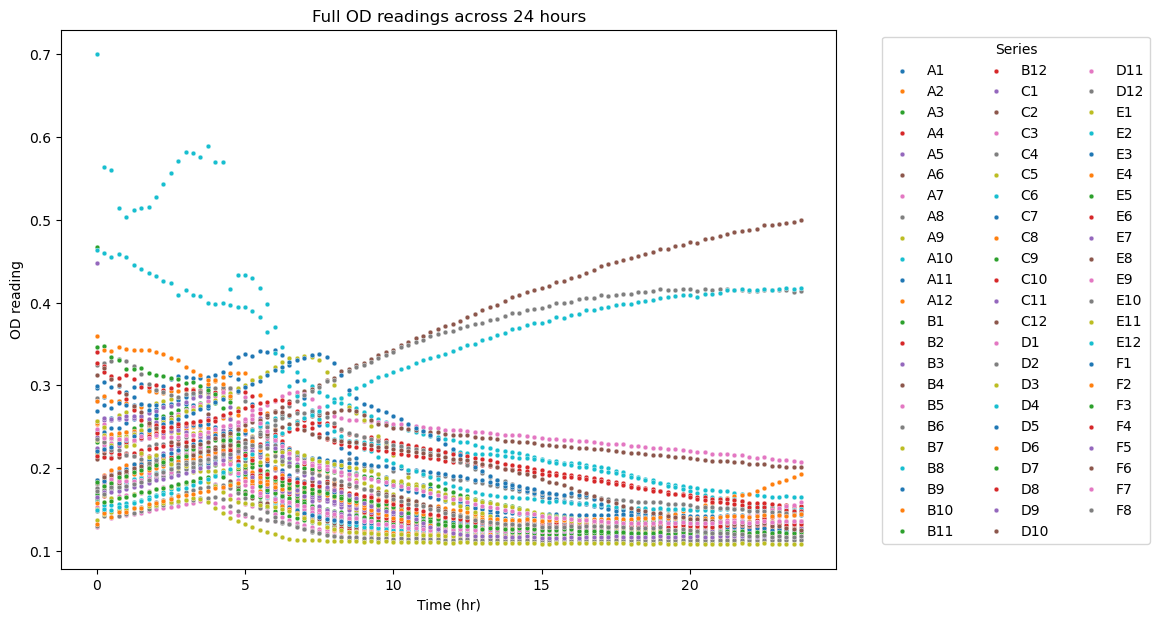

In [24]:
#plot timeseries
plt.figure(figsize=(10, 7))
for column in cleaned_df.columns:
    sns.scatterplot(data = cleaned_df, x = cleaned_df.index, y = cleaned_df[column], label=column, s=12)
    
plt.legend(title='Series', bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=3)  # Adjust the location as needed
plt.xlabel('Time (hr)')
plt.ylabel('OD reading')
plt.title('Full OD readings across 24 hours')

Text(0.5, 1.0, 'Positive Controls')

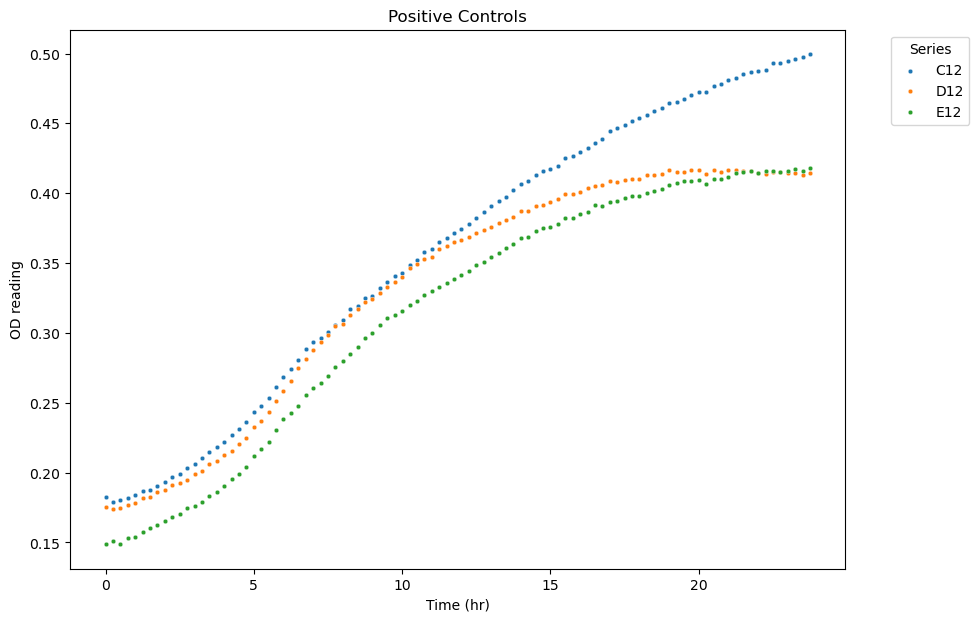

In [25]:
only_clean_wells = cleaned_df[['C12','D12','E12']]
plt.figure(figsize=(10, 7))
for column in only_clean_wells.columns:
    sns.scatterplot(data = only_clean_wells, x = cleaned_df.index, y = cleaned_df[column], label=column, s=11)
    
plt.legend(title='Series', bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=1)  # Adjust the location as needed
plt.xlabel('Time (hr)')
plt.ylabel('OD reading')
plt.title('Positive Controls')

Text(0.5, 1.0, 'Full OD readings across 24 hours')

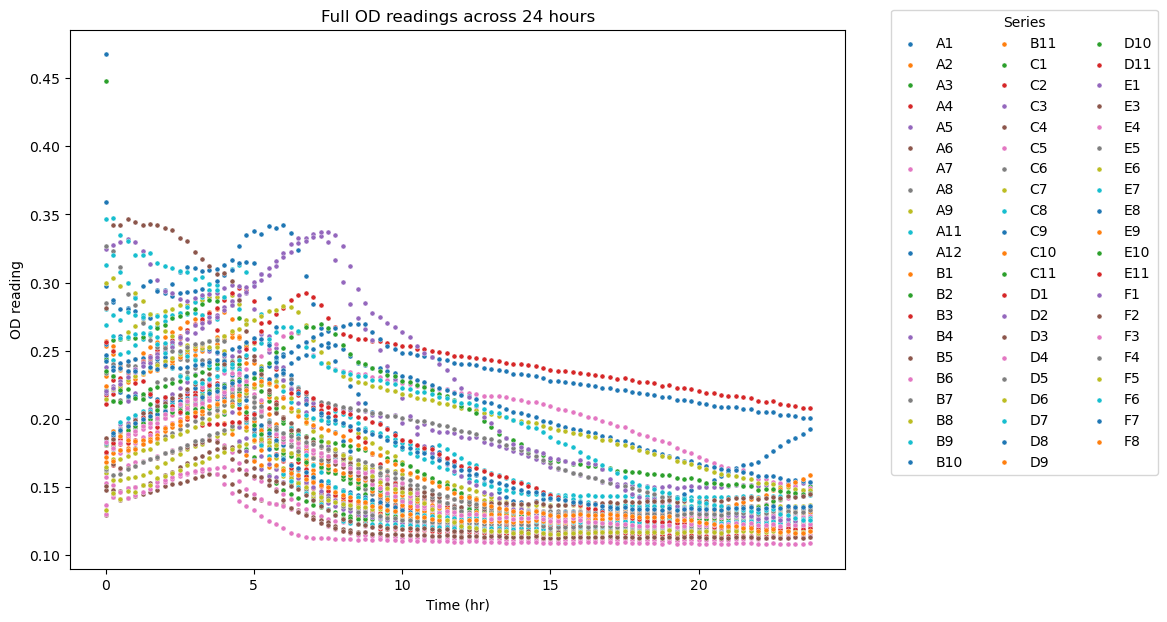

In [26]:
#drop pos controls and outliers
final_clean = cleaned_df.drop(columns = ['B12', 'C12', 'D12', 'A10', 'E12', 'E2'])

plt.figure(figsize=(10, 7))
for column in final_clean.columns:
    sns.scatterplot(data = final_clean, x = final_clean.index, y = final_clean[column], label=column, s=13)
    
plt.legend(title='Series', bbox_to_anchor=(1.05, 1.05), loc='upper left', ncol=3)  # Adjust the location as needed
plt.xlabel('Time (hr)')
plt.ylabel('OD reading')
plt.title('Full OD readings across 24 hours')

In [27]:
thousandPFUs =final_clean.loc[:,'A1':'C11']

ten_thousandPFUs = final_clean.loc[:, 'D1':'F8']


thousand_endpoint_df = pd.DataFrame({
    '15 min': thousandPFUs.iloc[1],
    '24 hr': thousandPFUs.iloc[-1]
})

ten_thousand_endpoint_df = pd.DataFrame({
    '15 min': ten_thousandPFUs.iloc[1],
    '24 hr': ten_thousandPFUs.iloc[-1]
})

#plot_with_r_squared(thousand_endpoint_df, x_col='15 min', y_col='24 hr', title = 'PFU 10^4 (OD < 0.35)')
#plot_with_r_squared(ten_thousand_endpoint_df, x_col='15 min', y_col='24 hr', title='PFU 10^3 (OD < 0.31)')
ten_thousandPFUs

Series,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,E10,E11,F1,F2,F3,F4,F5,F6,F7,F8
Time [s],,,,,,,,,,,,,,,,,,,,,
0.000000,0.2178,0.3247,0.1504,0.1825,0.1624,0.1328,0.3463,0.2426,0.2243,0.1814,...,0.2347,0.2565,0.2206,0.2813,0.1826,0.3269,0.1647,0.3130,0.2466,0.1720
0.250028,0.2282,0.3273,0.1668,0.1829,0.1778,0.1453,0.3476,0.2314,0.2228,0.1802,...,0.2311,0.2500,0.2227,0.3422,0.1787,0.3234,0.1706,0.3205,0.2358,0.1687
0.500056,0.2301,0.3299,0.1637,0.1747,0.1772,0.1410,0.3348,0.2194,0.2229,0.1873,...,0.2214,0.2369,0.2252,0.3420,0.1824,0.3116,0.1705,0.3079,0.2369,0.1768
0.750083,0.2348,0.3316,0.1642,0.1763,0.1771,0.1471,0.3302,0.2167,0.2270,0.1915,...,0.2219,0.2343,0.2303,0.3465,0.1886,0.2914,0.1726,0.2999,0.2349,0.1774
1.000111,0.2368,0.3297,0.1654,0.1820,0.1787,0.1466,0.3201,0.2165,0.2295,0.1944,...,0.2152,0.2261,0.2341,0.3443,0.1908,0.2837,0.1748,0.2890,0.2350,0.1780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22.752194,0.1194,0.1518,0.1185,0.1529,0.1341,0.1212,0.1309,0.1562,0.1307,0.1273,...,0.1469,0.1192,0.1256,0.1420,0.1215,0.1307,0.1164,0.1300,0.1346,0.1171
23.002222,0.1198,0.1526,0.1193,0.1504,0.1344,0.1217,0.1309,0.1553,0.1311,0.1276,...,0.1466,0.1195,0.1265,0.1435,0.1226,0.1321,0.1177,0.1297,0.1357,0.1176
23.252250,0.1198,0.1528,0.1193,0.1507,0.1344,0.1216,0.1310,0.1553,0.1314,0.1275,...,0.1458,0.1188,0.1252,0.1426,0.1220,0.1317,0.1170,0.1273,0.1354,0.1163


4.270569234717383

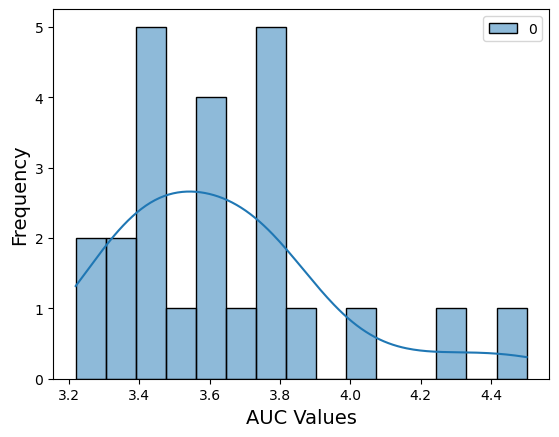

In [32]:
new31 = remove_outliers(thousandPFUs, 1, 0.15, 0.25)
new41 = remove_outliers(ten_thousandPFUs, 1, 0.15, 0.25)

auc_values_31 = {col: np.trapz(new31[col], x=new31.index) for col in new31.columns}

auc_values_41 = {col: np.trapz(new41[col], x=new41.index) for col in new41.columns}

sns.histplot(auc_values_31.values(), bins=15, kde=True)
plt.xlabel('AUC Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

sum(auc_values_41.values()) / len(auc_values_41.values())

Text(0, 0.5, 'Frequency')

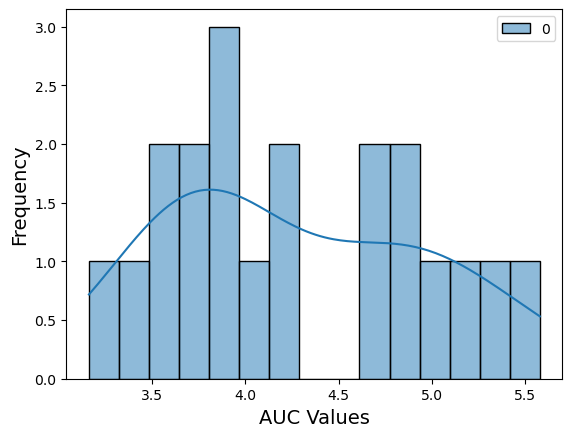

In [155]:
sns.histplot(auc_values_41.values(), bins=15, kde=True)
plt.xlabel('AUC Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

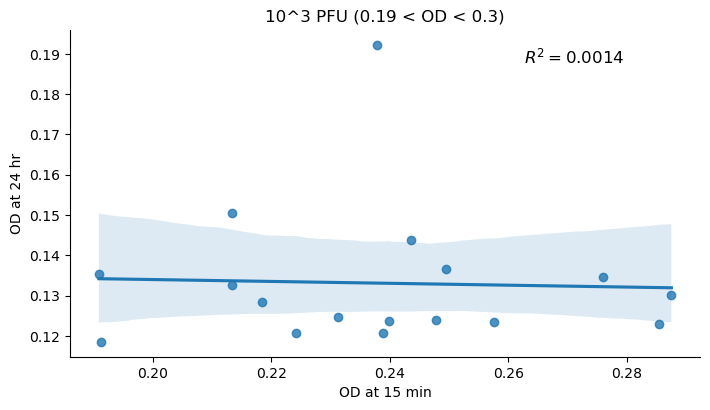

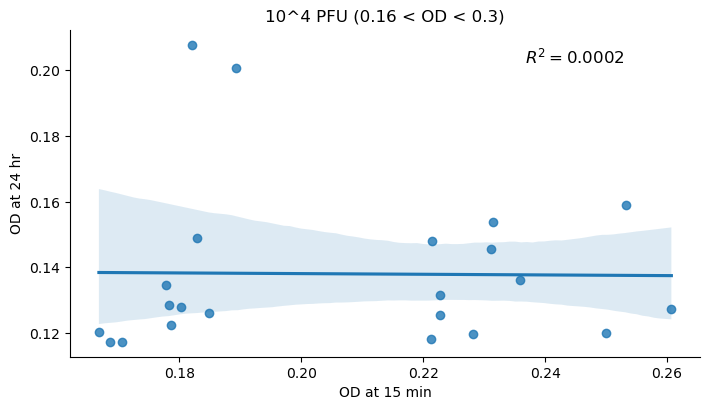

In [33]:
plot_with_r_squared(thousand_endpoint_df, x_col='15 min', y_col='24 hr', lower = 0.19, upper = 0.3, title = '10^3 PFU (0.19 < OD < 0.3)')
plot_with_r_squared(ten_thousand_endpoint_df, x_col='15 min', y_col='24 hr', lower = 0.16, upper = 0.3, title='10^4 PFU (0.16 < OD < 0.3)')

----start of new trial-----

In [34]:
df = pd.read_csv('/Users/kelly/Desktop/CE-KH_RBG_10312024.csv')

In [35]:
cleaned_df = clean_and_transpose(df, start_row=32, end_row=106)
cleaned_df

Series,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12
Time [s],,,,,,,,,,,,,,,,,,,,,
0.000000,0.2568,0.2144,0.1973,0.2805,0.2029,0.2184,0.2564,0.1555,0.2329,0.1820,...,0.0865,0.0870,0.1321,0.2109,0.1655,0.1609,0.2601,0.1735,0.1333,0.1837
0.250028,0.2515,0.2382,0.1997,0.2938,0.2086,0.2170,0.2747,0.1586,0.2416,0.1844,...,0.0864,0.0868,0.1422,0.2095,0.1700,0.1652,0.2588,0.1734,0.1442,0.1833
0.500056,0.2579,0.2526,0.2047,0.2996,0.2147,0.2178,0.2807,0.1641,0.2499,0.1910,...,0.0865,0.0869,0.1407,0.2156,0.1745,0.1720,0.2601,0.1746,0.1451,0.1861
0.750083,0.2609,0.2450,0.2073,0.2952,0.2082,0.2361,0.2849,0.1663,0.2548,0.1938,...,0.0862,0.0865,0.1413,0.2197,0.1769,0.1751,0.2606,0.1752,0.1477,0.1897
1.000083,0.2693,0.2482,0.2103,0.2929,0.2119,0.2358,0.2857,0.1695,0.2593,0.1969,...,0.0855,0.0858,0.1414,0.2214,0.1802,0.1760,0.2585,0.1761,0.1487,0.1919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22.752167,0.3506,0.2009,0.1727,0.3229,0.3036,0.3405,0.3645,0.2556,0.2877,0.1806,...,0.0871,0.0875,0.1304,0.1996,0.1590,0.2318,0.4053,0.2280,0.2867,0.3353
23.002194,0.3495,0.1986,0.1712,0.3216,0.3024,0.3401,0.3633,0.2554,0.2864,0.1786,...,0.0868,0.0871,0.1307,0.1974,0.1566,0.2306,0.4071,0.2272,0.2868,0.3372
23.252222,0.3480,0.1970,0.1698,0.3195,0.3012,0.3389,0.3630,0.2542,0.2854,0.1760,...,0.0864,0.0868,0.1304,0.1948,0.1559,0.2278,0.4079,0.2260,0.2860,0.3366


Text(0.5, 1.0, 'Full OD readings across 24 hours')

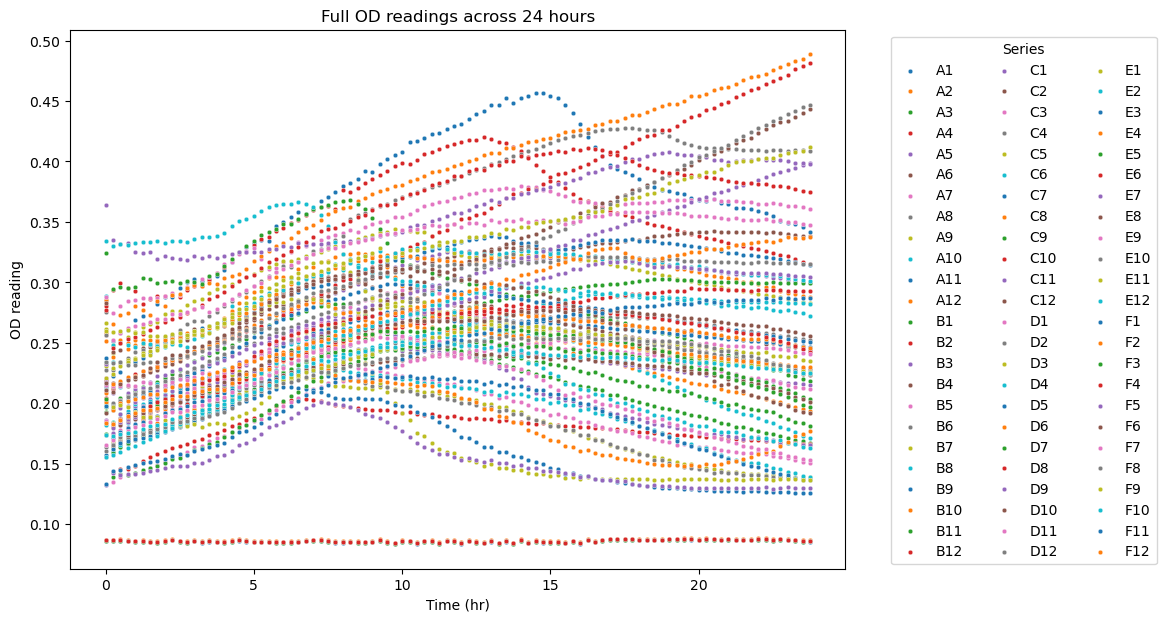

In [36]:
plt.figure(figsize=(10, 7))
for column in cleaned_df.columns:
    sns.scatterplot(data = cleaned_df, x = cleaned_df.index, y = cleaned_df[column], label=column, s=11)
    
plt.legend(title='Series', bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=3)  # Adjust the location as needed
plt.xlabel('Time (hr)')
plt.ylabel('OD reading')
plt.title('Full OD readings across 24 hours')

Text(0.5, 1.0, 'Full OD readings across 24 hours')

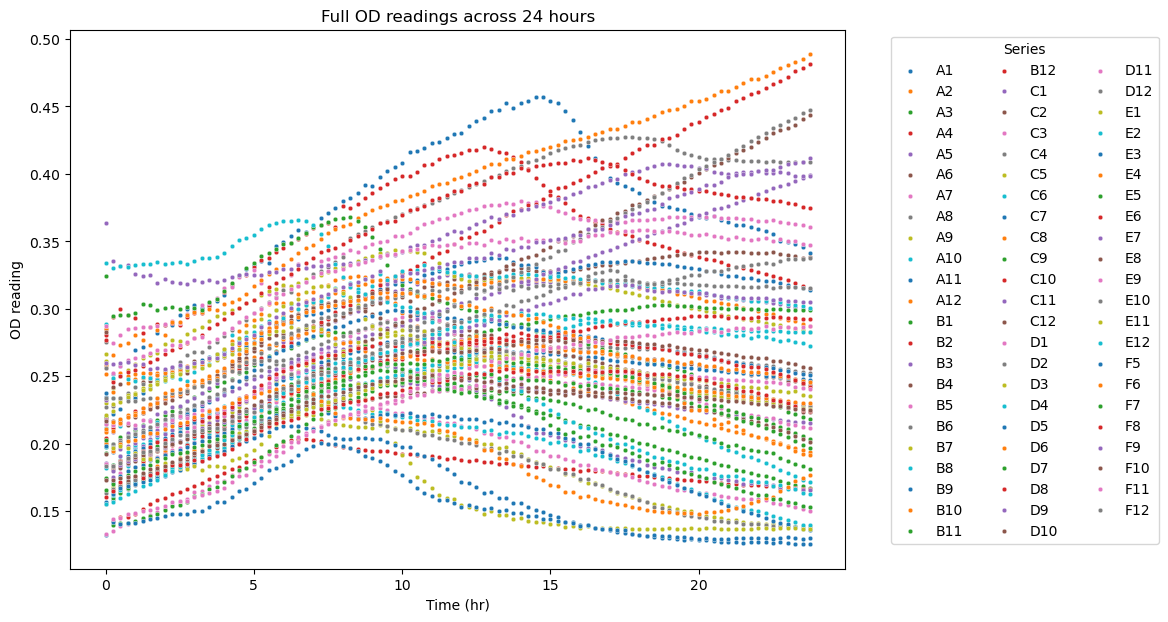

In [37]:
#So now we need to clean the data. Rows F1-4 have no data, so I'll drop those rows
only_clean_wells = cleaned_df[['B12','C12','D12']]
cleaned_df = cleaned_df.drop(columns = cleaned_df.loc[:, 'F1':'F4'].columns)
plt.figure(figsize=(10, 7))
for column in cleaned_df.columns:
    sns.scatterplot(data = cleaned_df, x = cleaned_df.index, y = cleaned_df[column], label=column, s=11)
    
plt.legend(title='Series', bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=3)  # Adjust the location as needed
plt.xlabel('Time (hr)')
plt.ylabel('OD reading')
plt.title('Full OD readings across 24 hours')

Text(0.5, 1.0, 'Full OD readings across 24 hours')

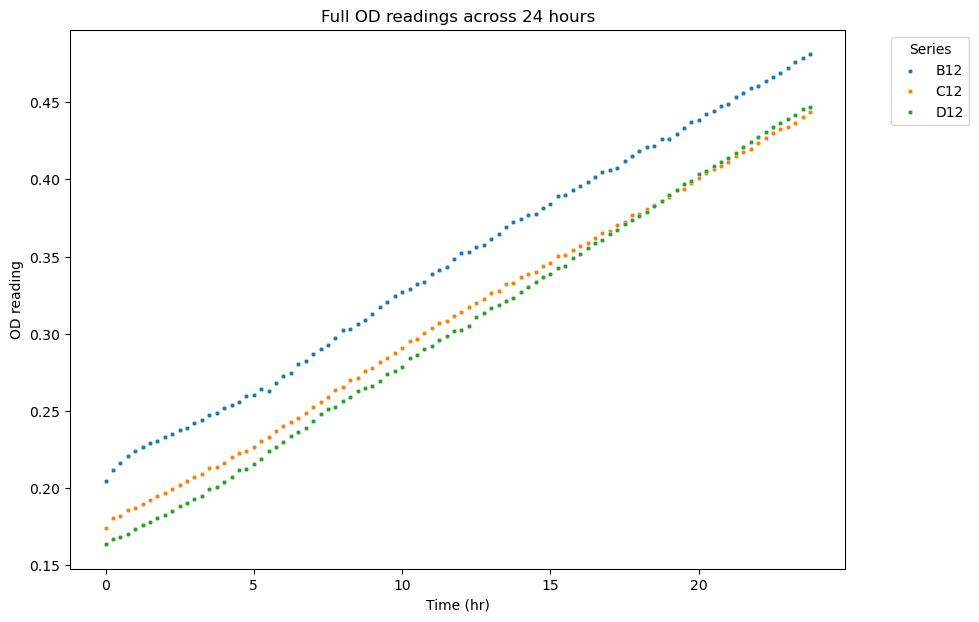

In [38]:
#now we also have some positive control wells. with just bacteria and broth, no phage. to prove that it can grow itselg
#lets identify those on the graph

only_clean_wells = cleaned_df[['B12','C12','D12']]
plt.figure(figsize=(10, 7))
for column in only_clean_wells.columns:
    sns.scatterplot(data = only_clean_wells, x = only_clean_wells.index, y = only_clean_wells[column], label=column, s=11)
    plt.legend(title='Series', bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=1)  # Adjust the location as needed
plt.xlabel('Time (hr)')
plt.ylabel('OD reading')
plt.title('Full OD readings across 24 hours')

Text(0.5, 1.0, 'Full OD readings across 24 hours')

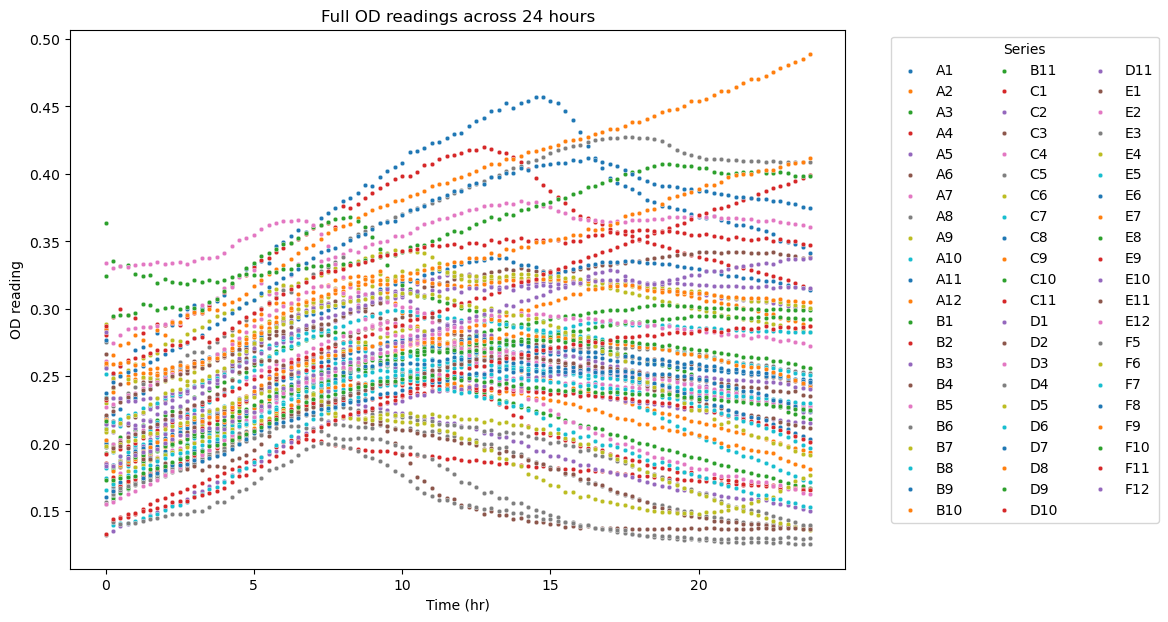

In [39]:
#This looks great. We can tell this bacteria growth was uninhibited. So lets drop these from our graph

final_clean = cleaned_df.drop(columns = ['B12', 'C12', 'D12'])
plt.figure(figsize=(10, 7))
for column in final_clean.columns:
    sns.scatterplot(data = final_clean, x = final_clean.index, y = final_clean[column], label=column, s=11)
    
plt.legend(title='Series', bbox_to_anchor=(1.05, 1.0), loc='upper left', ncol=3)  # Adjust the location as needed
plt.xlabel('Time (hr)')
plt.ylabel('OD reading')
plt.title('Full OD readings across 24 hours')

So now if u examine our index we will not have our positive control wells nor our rows with no phage

Our goal is for there to be no association between starting and ending density across 24 hours
so some of these lines like the yellow one going straight up are no good. because we know that the starting OD 
too high for the phage to cause any damage
we want to quantify a optimal concentration that the phage can infect at, this way when we test the phage on
our evolved strains, we can be sure that the phage is affecting the bacteria

so lets go find if there is correlation between starting and final OD

show the picture of well plate??
what I've done is split the well plate into 2 sections
in one we use a lower density of phage (10^3 PFU)
in the other we use a higher density of phage (10^4 PFU)
I want to see which PFU concentration will give us more variability in results

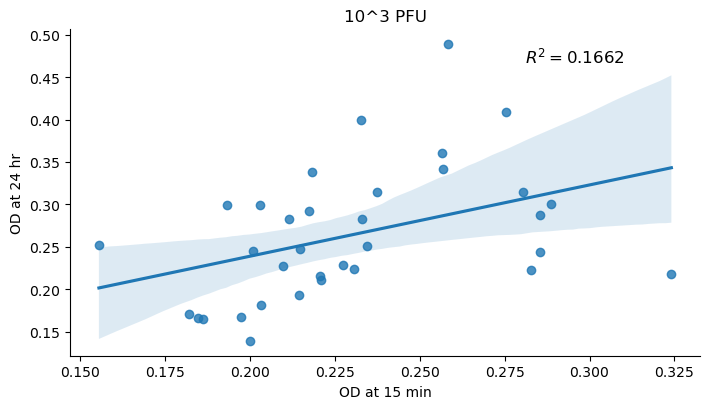

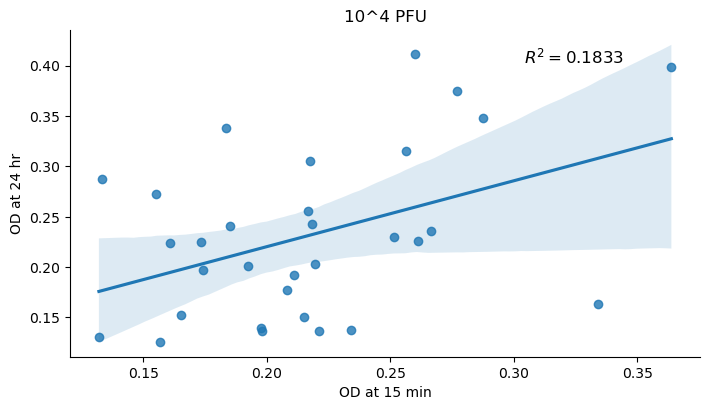

In [40]:
thousandPFUs =final_clean.loc[:,'A1':'C11']

ten_thousandPFUs = final_clean.loc[:, 'D1':]

thousand_endpoint_df = pd.DataFrame({
    '15 min': thousandPFUs.iloc[0],
    '24 hr': thousandPFUs.iloc[-1] 
})

ten_thousand_endpoint_df = pd.DataFrame({
    '15 min': ten_thousandPFUs.iloc[0],
    '24 hr': ten_thousandPFUs.iloc[-1]
})

plot_with_r_squared(thousand_endpoint_df, x_col='15 min', y_col='24 hr', title = '10^3 PFU')
plot_with_r_squared(ten_thousand_endpoint_df, x_col='15 min', y_col='24 hr', title = '10^4 PFU' )


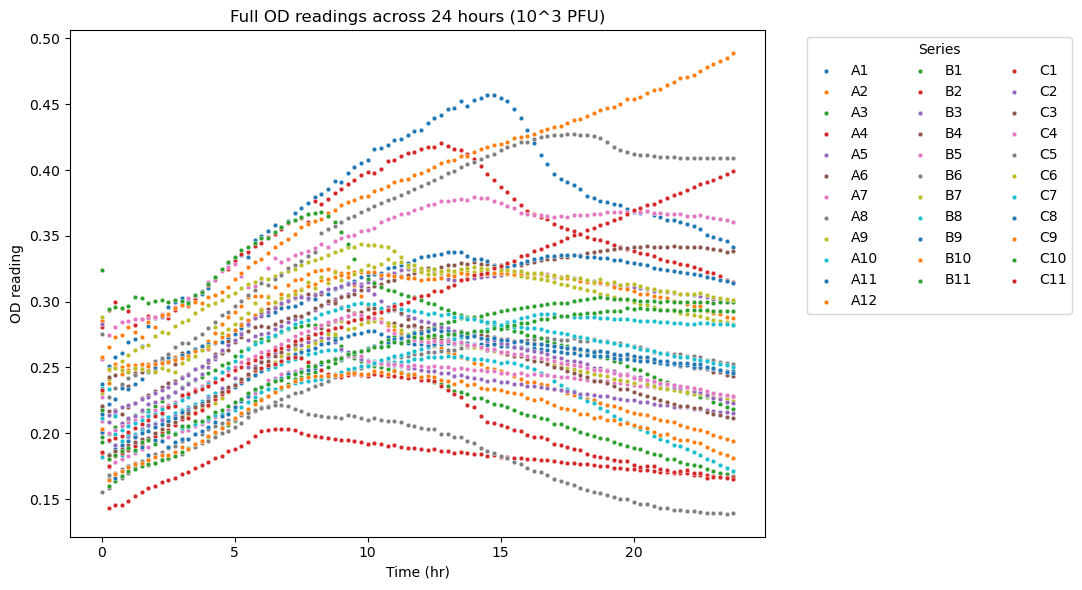

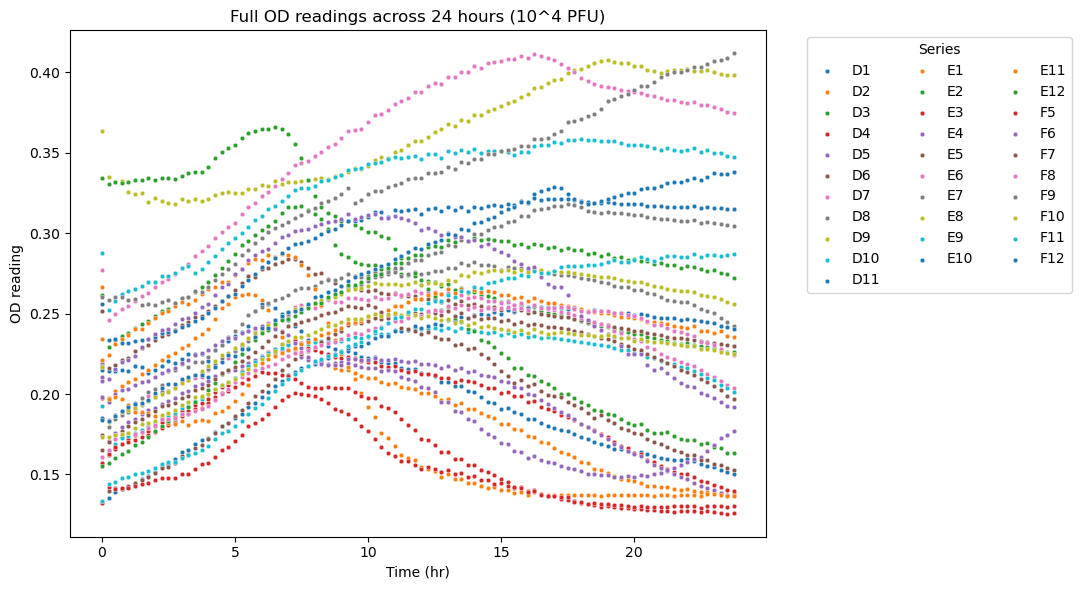

In [41]:
plot_timeseries(thousandPFUs, 'Full OD readings across 24 hours (10^3 PFU)')
plot_timeseries(ten_thousandPFUs, 'Full OD readings across 24 hours (10^4 PFU)')

In [42]:
thousand_endpoint_df.sort_values('15 min')

,15 min,24 hr
Series,,
A8,0.1555,0.2524
A10,0.1820,0.1716
B2,0.1847,0.1665
C1,0.1861,0.1656
B11,0.1932,0.2994
A3,0.1973,0.1676
C5,0.2000,0.1394
C8,0.2009,0.2455
A5,0.2029,0.2997


Hmmm it actually looks to be pretty good. The R^2 is under 0.2, which is what we want. However, you can see
The variance gets a little wide near the end. Lets remove outliers maybe its skewing out data

Lets filter for starting ODs under 0.3 

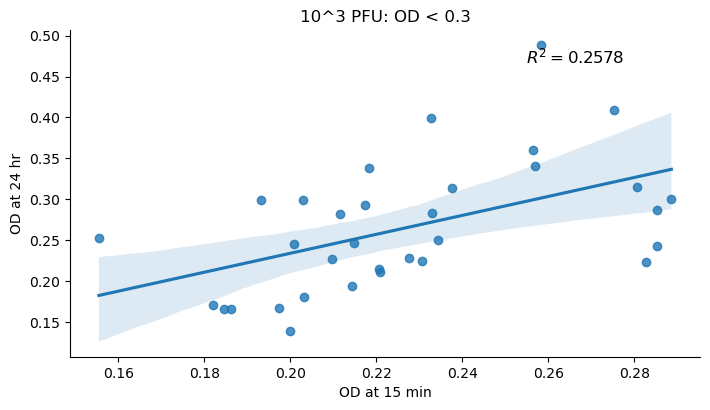

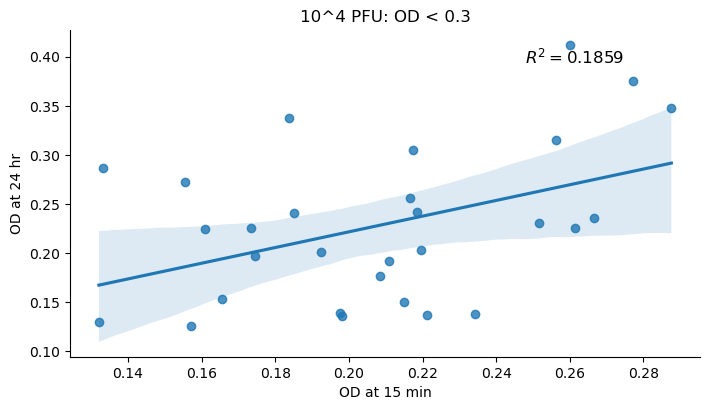

In [43]:
#so what we did earlier was sort on this 15 min column
#now we want to remove all values over 0.3

plot_with_r_squared(thousand_endpoint_df, x_col='15 min', y_col='24 hr', upper=0.3, title = '10^3 PFU: OD < 0.3')
plot_with_r_squared(ten_thousand_endpoint_df, x_col='15 min', y_col='24 hr', upper=0.3, title = '10^4 PFU: OD < 0.3')


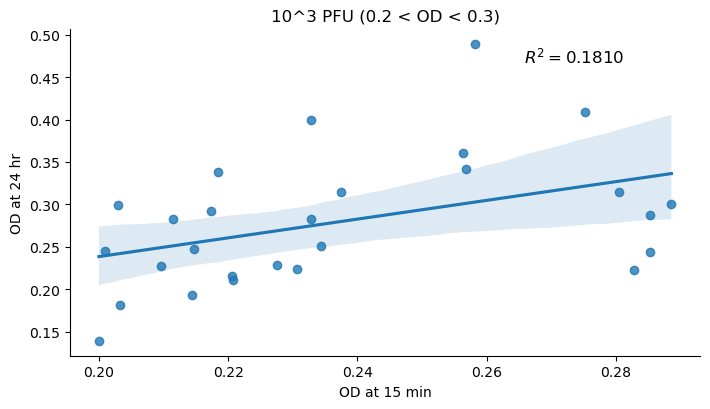

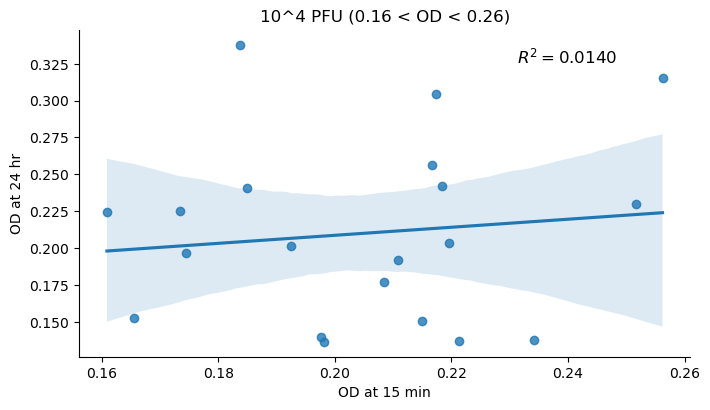

In [44]:
#long story short I trial and errored, finding the optimal parameters for a minimized r^2 value
plot_with_r_squared(thousand_endpoint_df, x_col='15 min', y_col='24 hr', lower = 0.2, upper=0.3, title = '10^3 PFU (0.2 < OD < 0.3)')
plot_with_r_squared(ten_thousand_endpoint_df, x_col='15 min', y_col='24 hr', lower = 0.16, upper=0.26, title = '10^4 PFU (0.16 < OD < 0.26)')

We can see that the 10^4 PFU is giving us more variability, meaning at this PFU, phage has 'enough virulence' 
to kill the bacteria


Text(0.5, 0, 'AUC')

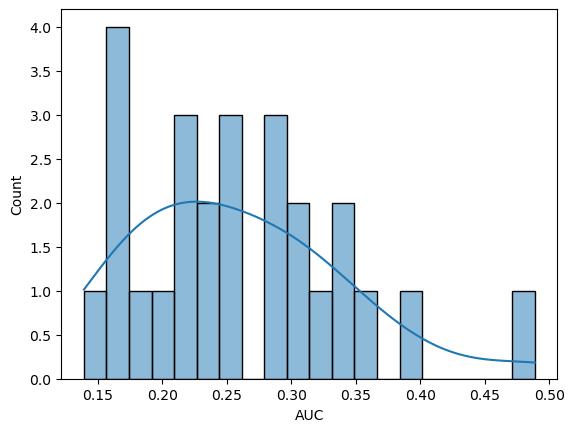

In [45]:
thousand_endpoint_df = thousand_endpoint_df.sort_values('15 min')
filtered_df = thousand_endpoint_df.loc[(thousand_endpoint_df['15 min'] >= 0.16) & (thousand_endpoint_df['15 min'] <= 0.26)]
filtered_df

sns.histplot(filtered_df['24 hr'], bins=20, kde=True)
plt.xlabel('AUC')

5.948998525881108

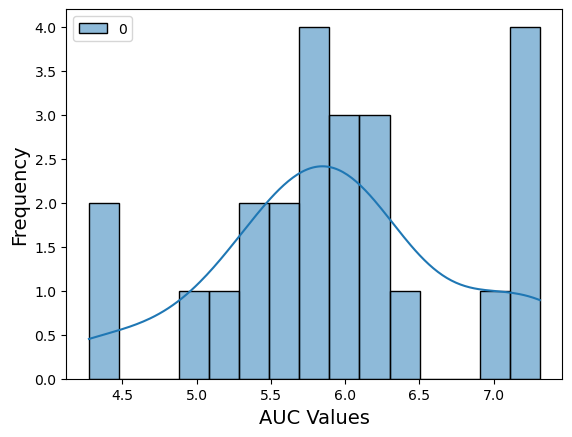

In [50]:
new3 = remove_outliers(thousandPFUs, 0, 0.15, 0.25)
new4 = remove_outliers(ten_thousandPFUs, 0, 0.15, 0.25)

auc_values_3 = {col: np.trapz(new3[col], x=new3.index) for col in new3.columns}

auc_values_4 = {col: np.trapz(new4[col], x=new4.index) for col in new4.columns}

sns.histplot(auc_values_3.values(), bins=15, kde=True)
plt.xlabel('AUC Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

sum(auc_values_3.values()) / len(auc_values_3.values())
#sum(auc_values_4.values()) / len(auc_values_4.values())

Text(0, 0.5, 'Frequency')

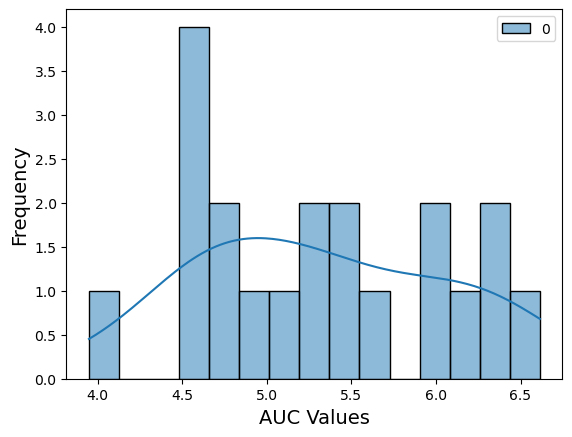

In [139]:
sns.histplot(auc_values_4.values(), bins=15, kde=True)
plt.xlabel('AUC Values', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

In [47]:
area = simpson(filtered_df['24 hr'], dx=8)
area

51.149933553333334

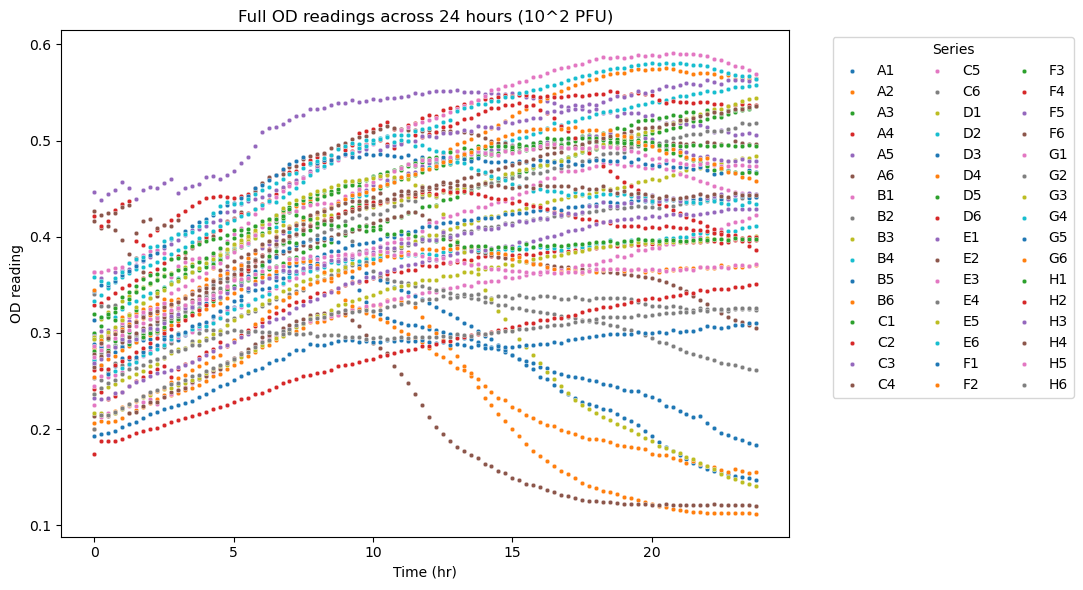

In [48]:
df100 = pd.read_csv('/Users/kelly/Downloads/CE_KH_RBG092624.xlsx - 100PFUs.csv')
df100 = clean_and_transpose(df100, start_row=0, end_row=92).dropna(axis=1)
df100
plot_timeseries(df100, 'Full OD readings across 24 hours (10^2 PFU)')

Why did you scroll so far. LOL